In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
import pickle
import itertools

In [36]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

In [37]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [38]:
def seperateCNN():
    input1 = keras.Input(shape=(10, 12, 1))
    input2 = keras.Input(shape=(46, 12, 1))

    x = layers.Conv2D(filters=16, kernel_size=(2, 12))(input1)  # 9
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.Conv2D(filters=32, kernel_size=(2, 1))(x)    # 8
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPool2D(pool_size=(2, 1), strides=(2, 1))(x)  # 4
    x = layers.Flatten()(x)
    x = keras.Model(inputs=input1, outputs=x)

    y = layers.Conv2D(filters=16, kernel_size=(15, 12))(input2)     # 32
    y = layers.BatchNormalization()(y)
    y = keras.activations.relu(y)
    y = layers.MaxPool2D(pool_size=(2, 1), strides=(2, 1))(y)  # 16
    y = layers.Conv2D(filters=32,kernel_size=(9,1))(y)    # 8
    y = layers.BatchNormalization()(y)
    y = keras.activations.relu(y)
    y = layers.MaxPool2D(pool_size=(2, 1),strides=(2,1))(y)  # 4
    y = layers.Flatten()(y)
    y = keras.Model(inputs=input2,outputs=y)

    combined = layers.concatenate([x.output,y.output])
    z = layers.Dense(128,activation='relu')(combined)
    z = layers.Dropout(0.2)(z)
    z = layers.Dense(1,activation='sigmoid')(z)

    model = keras.Model(inputs=[input1,input2],outputs=z)
    return model

def pull_peptide_aaindex(dataset):
    result = np.empty([len(dataset),10,12,1])
    for i in range(len(dataset)):
        result[i,:,:,:] = dataset[i][0]
    return result


def pull_hla_aaindex(dataset):
    result = np.empty([len(dataset),46,12,1])
    for i in range(len(dataset)):
        result[i,:,:,:] = dataset[i][1]
    return result


def pull_label_aaindex(dataset):
    col = [item[2] for item in dataset]
    result = [0 if item == 'Negative' else 1 for item in col]
    result = np.expand_dims(np.array(result),axis=1)
    return result

def pull_label_aaindex(dataset):
    result = np.empty([len(dataset),1])
    for i in range(len(dataset)):
        result[i,:] = dataset[i][2]
    return result

def aaindex(peptide,after_pca):

    amino = 'ARNDCQEGHILKMFPSTWYV-'
    matrix = np.transpose(after_pca)   # [12,21]
    encoded = np.empty([len(peptide), 12])  # (seq_len,12)
    for i in range(len(peptide)):
        query = peptide[i]
        if query == 'X': query = '-'
        query = query.upper()
        encoded[i, :] = matrix[:, amino.index(query)]

    return encoded

def peptide_data_aaindex(peptide,after_pca):   # return numpy array [10,12,1]
    length = len(peptide)
    if length == 10:
        encode = aaindex(peptide,after_pca)
    elif length == 9:
        peptide = peptide[:5] + '-' + peptide[5:]
        encode = aaindex(peptide,after_pca)
    encode = encode.reshape(encode.shape[0], encode.shape[1], -1)
    return encode

def dict_inventory(inventory):
    dicA, dicB, dicC = {}, {}, {}
    dic = {'A': dicA, 'B': dicB, 'C': dicC}

    for hla in inventory:
        type_ = hla[4]  # A,B,C
        first2 = hla[6:8]  # 01
        last2 = hla[8:]  # 01
        try:
            dic[type_][first2].append(last2)
        except KeyError:
            dic[type_][first2] = []
            dic[type_][first2].append(last2)

    return dic


def rescue_unknown_hla(hla, dic_inventory):
    type_ = hla[4]
    first2 = hla[6:8]
    last2 = hla[8:]
    big_category = dic_inventory[type_]
    #print(hla)
    if not big_category.get(first2) == None:
        small_category = big_category.get(first2)
        distance = [abs(int(last2) - int(i)) for i in small_category]
        optimal = min(zip(small_category, distance), key=lambda x: x[1])[0]
        return 'HLA-' + str(type_) + '*' + str(first2) + str(optimal)
    else:
        small_category = list(big_category.keys())
        distance = [abs(int(first2) - int(i)) for i in small_category]
        optimal = min(zip(small_category, distance), key=lambda x: x[1])[0]
        return 'HLA-' + str(type_) + '*' + str(optimal) + str(big_category[optimal][0])






def hla_data_aaindex(hla_dic,hla_type,after_pca):    # return numpy array [34,12,1]
    try:
        seq = hla_dic[hla_type]
    except KeyError:
        hla_type = rescue_unknown_hla(hla_type,dic_inventory)
        seq = hla_dic[hla_type]
    encode = aaindex(seq,after_pca)
    encode = encode.reshape(encode.shape[0], encode.shape[1], -1)
    return encode

def construct_aaindex(ori,hla_dic,after_pca):
    series = []
    for i in range(ori.shape[0]):
        peptide = ori['peptide'].iloc[i]
        hla_type = ori['HLA'].iloc[i]
        immuno = np.array(ori['immunogenicity'].iloc[i]).reshape(1,-1)   # [1,1]

        encode_pep = peptide_data_aaindex(peptide,after_pca)    # [10,12]

        encode_hla = hla_data_aaindex(hla_dic,hla_type,after_pca)   # [46,12]
        series.append((encode_pep, encode_hla, immuno))
    return series

def hla_df_to_dic(hla):
    dic = {}
    for i in range(hla.shape[0]):
        col1 = hla['HLA'].iloc[i]  # HLA allele
        col2 = hla['pseudo'].iloc[i]  # pseudo sequence
        dic[col1] = col2
    return dic

def retain_910(ori):
    cond = []
    for i in range(ori.shape[0]):
        peptide = ori['peptide'].iloc[i]
        if len(peptide) == 9 or len(peptide) == 10:
            cond.append(True)
        else:
            cond.append(False)
    data = ori.loc[cond]
    data = data.set_index(pd.Index(np.arange(data.shape[0])))
    return data


In [39]:
def read_fasta_and_chop_to_N(path,N):
    with open(path,'r') as f:
        lis = f.readlines()[1:]
    lis = [raw.rstrip('\n') for raw in lis]
    seq = ''.join(lis)
    bucket = []
    for i in range(0,len(seq)-N+1,1):
        frag = seq[i:i+N]
        bucket.append(frag)
    return seq,bucket

In [40]:
def set_query_df(frag):
    from itertools import product
    hla = ['HLA-A*0101','HLA-A*0201','HLA-A*0301','HLA-A*1101','HLA-A*2402','HLA-B*0702','HLA-B*0801','HLA-B*1501','HLA-B*4001','HLA-C*0702']
    combine = list(product(frag,hla))
    col1 = [item[0] for item in combine]  # peptide
    col2 = [item[1] for item in combine]  # hla
    col3 = [0 for item in combine]   # immunogenicity
    df = pd.DataFrame({'peptide':col1,'HLA':col2,'immunogenicity':col3})
    return df

In [41]:
def get_score(ori):
    dataset = construct_aaindex(ori,hla_dic,after_pca)
    input1 = pull_peptide_aaindex(dataset)
    input2 = pull_hla_aaindex(dataset)


    result = cnn_model.predict([input1,input2])
    ori['result'] = result[:,0]
    return ori

In [42]:
def prepare_plot_each_region(score_df,count,h=10):  # how many hla you query
    from itertools import repeat
    # x coordinate
    x = []
    for i in range(count):
        x.extend(list(repeat(i,h)))
    # y coordinate
    y = score_df['result'].values
    # color coordiate
    tmp = list(repeat([0,1,2,3,4,5,6,7,8,9],count))
    c = [j for i in tmp for j in i]
#     # plot
#     fig,ax = plt.subplots()
#     ax.scatter(x=x,y=y,c=c,cmap='tab10',alpha=1,s=5)
#     plt.show()
    return x,y,c

In [43]:
def prepare_plot_each_region_mean(score_df,count,h=10):
    lis = np.split(score_df['result'].values,count)
    y = np.array([item.mean() for item in lis])
#     fig,ax = plt.subplots()
#     ax.bar(x=np.arange(count),height=y)
#     plt.show()
    return y

In [44]:
def wrapper(frag,count):
    orf_score_df = set_query_df(frag)
    orf_score_df = get_score(orf_score_df)
    x,y,c = prepare_plot_each_region(orf_score_df,count)
    y = prepare_plot_each_region_mean(orf_score_df,count)
    return y

In [45]:
'''
orf1ab: polypeptide, nsp, replicase..., length 7096, 9mer: 7088, 10mer: 7087
orf2: spike, length 1273, 9mer: 1265, 10mer: 1264
orf3a: accessory, length 275, 9mer: 267, 10mer: 266
orf4: envelope, length 75, 9mer: 67, 10mer: 66
orf5: membrane, length 222, 9mer: 214, 10mer: 213
orf6: accessory, length 61, 9mer: 53, 10mer: 52
orf7a: accessory, length 121, 9mer 113, 10mer: 112
orf7b: accessory, length 43, 9mer 35   (missing in nature immunology paper), 10mer: 34
orf8: accessory, length 121, 9mer 113, 10mer: 112
orf9: nucleocapside glycoprotein, length 419, 9mer 411, 10mer 410
orf10: accessory, length 38, 9mer: 30, 10mer: 29
'''

'\norf1ab: polypeptide, nsp, replicase..., length 7096, 9mer: 7088, 10mer: 7087\norf2: spike, length 1273, 9mer: 1265, 10mer: 1264\norf3a: accessory, length 275, 9mer: 267, 10mer: 266\norf4: envelope, length 75, 9mer: 67, 10mer: 66\norf5: membrane, length 222, 9mer: 214, 10mer: 213\norf6: accessory, length 61, 9mer: 53, 10mer: 52\norf7a: accessory, length 121, 9mer 113, 10mer: 112\norf7b: accessory, length 43, 9mer 35   (missing in nature immunology paper), 10mer: 34\norf8: accessory, length 121, 9mer 113, 10mer: 112\norf9: nucleocapside glycoprotein, length 419, 9mer 411, 10mer 410\norf10: accessory, length 38, 9mer: 30, 10mer: 29\n'

In [46]:
# set up the model and necessaray files for getting score of each SARS-CoV-2 region
cnn_model = seperateCNN()
cnn_model.load_weights('../data/models/cnn_model_331_3_7/')
after_pca = np.loadtxt('../data/after_pca.txt')
hla = pd.read_csv('../data/hla2paratopeTable_aligned.txt',sep='\t')
hla_dic = hla_df_to_dic(hla)
inventory = list(hla_dic.keys())
dic_inventory = dict_inventory(inventory)

In [47]:
# first consider 9-mer
orf1ab_seq,orf1ab_frag = read_fasta_and_chop_to_N('../data/covid/ORF1ab.fa',9)
orf2_seq, orf2_frag = read_fasta_and_chop_to_N('../data/covid/ORF2-spike.fa', 9)
orf3a_seq, orf3a_frag = read_fasta_and_chop_to_N('../data/covid/ORF3a-accessory.fa', 9)
orf4, orf4_frag = read_fasta_and_chop_to_N('../data/covid/ORF4-env.fa', 9)
orf5, orf5_frag = read_fasta_and_chop_to_N('../data/covid/ORF5-mem.fa', 9)
orf6, orf6_frag = read_fasta_and_chop_to_N('../data/covid/ORF6-accessory.fa', 9)
orf7a, orf7a_frag = read_fasta_and_chop_to_N('../data/covid/ORF7a-accessory.fa', 9)
orf7b,orf7b_frag = read_fasta_and_chop_to_N('../data/covid/ORF7b-accessory.fa', 9)
orf8,orf8_frag = read_fasta_and_chop_to_N('../data/covid/ORF8-accessory.fa', 9)
orf9,orf9_frag = read_fasta_and_chop_to_N('../data/covid/ORF9-nuc.fa', 9)
orf10,orf10_frag = read_fasta_and_chop_to_N('../data/covid/ORF10-accessory.fa', 9)

y1 = wrapper(orf1ab_frag,7088)
y2 = wrapper(orf2_frag,1265)
y3 = wrapper(orf3a_frag,267)
y4 = wrapper(orf4_frag,67)
y5 = wrapper(orf5_frag,214)
y6 = wrapper(orf6_frag,53)
y7 = wrapper(orf7a_frag,113)
y7b = wrapper(orf7b_frag,35)
y8 = wrapper(orf8_frag,113)
y9 = wrapper(orf9_frag,411)
y10 = wrapper(orf10_frag,30)

Text(0, 0.5, 'Average immunogenicity score')

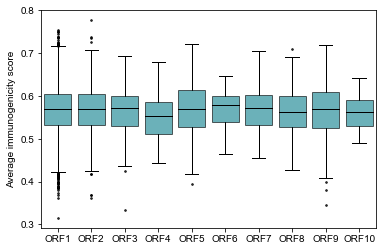

In [48]:
fig,ax = plt.subplots()
bp = ax.boxplot([y1,y2,y3,y4,y5,y6,y7,y8,y9,y10],positions=[0,1,2,3,4,5,6,7,8,9],patch_artist=True,widths=0.8)  # bp is a dictionary
for box in bp['boxes']:   # box is matplotlib.lines.Line2d object
    box.set(facecolor='#087E8B',alpha=0.6,linewidth=1)
for whisker in bp['whiskers']:
    whisker.set(linewidth=1)
for median in bp['medians']:
    median.set(color='black',linewidth=1)
for flier in bp['fliers']:
    flier.set(markersize=1.5)
ax.set_xticks(np.arange(10))
ax.set_xticklabels(['ORF1','ORF2','ORF3','ORF4','ORF5','ORF6','ORF7','ORF8','ORF9','ORF10'])
ax.set_ylabel('Average immunogenicity score')

In [49]:
# let's inspect 10mer
orf1ab_seq,orf1ab_frag = read_fasta_and_chop_to_N('../data/covid/ORF1ab.fa',10)
orf2_seq, orf2_frag = read_fasta_and_chop_to_N('../data/covid/ORF2-spike.fa', 10)
orf3a_seq, orf3a_frag = read_fasta_and_chop_to_N('../data/covid/ORF3a-accessory.fa', 10)
orf4, orf4_frag = read_fasta_and_chop_to_N('../data/covid/ORF4-env.fa', 10)
orf5, orf5_frag = read_fasta_and_chop_to_N('../data/covid/ORF5-mem.fa', 10)
orf6, orf6_frag = read_fasta_and_chop_to_N('../data/covid/ORF6-accessory.fa', 10)
orf7a, orf7a_frag = read_fasta_and_chop_to_N('../data/covid/ORF7a-accessory.fa', 10)
orf7b,orf7b_frag = read_fasta_and_chop_to_N('../data/covid/ORF7b-accessory.fa', 10)
orf8,orf8_frag = read_fasta_and_chop_to_N('../data/covid/ORF8-accessory.fa', 10)
orf9,orf9_frag = read_fasta_and_chop_to_N('../data/covid/ORF9-nuc.fa', 10)
orf10,orf10_frag = read_fasta_and_chop_to_N('../data/covid/ORF10-accessory.fa', 10)

y1 = wrapper(orf1ab_frag,7087)
y2 = wrapper(orf2_frag,1264)
y3 = wrapper(orf3a_frag,266)
y4 = wrapper(orf4_frag,66)
y5 = wrapper(orf5_frag,213)
y6 = wrapper(orf6_frag,52)
y7a = wrapper(orf7a_frag,112)
y7b = wrapper(orf7b_frag,34)
y8 = wrapper(orf8_frag,112)
y9 = wrapper(orf9_frag,410)
y10 = wrapper(orf10_frag,29)

Text(0, 0.5, 'Average immunogenicity score')

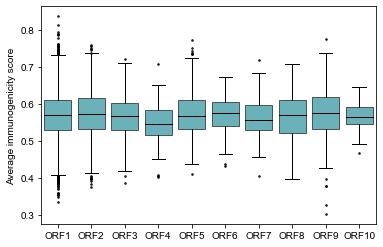

In [50]:
fig, ax = plt.subplots()
bp = ax.boxplot([y1, y2, y3, y4, y5, y6, y7a, y8, y9, y10], positions=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                patch_artist=True, widths=0.8)  # bp is a dictionary
for box in bp['boxes']:  # box is matplotlib.lines.Line2d object
    box.set(facecolor='#087E8B', alpha=0.6, linewidth=1)
for whisker in bp['whiskers']:
    whisker.set(linewidth=1)
for median in bp['medians']:
    median.set(color='black', linewidth=1)
for flier in bp['fliers']:
    flier.set(markersize=1.5)
ax.set_xticks(np.arange(10))
ax.set_xticklabels(['ORF1', 'ORF2', 'ORF3', 'ORF4', 'ORF5', 'ORF6', 'ORF7', 'ORF8', 'ORF9', 'ORF10'])
ax.set_ylabel('Average immunogenicity score')